In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
import librosa
import librosa.display

import warnings
warnings.filterwarnings('ignore')

In [2]:
speech_reader = pd.read_csv("C:/Python/PlayArea/speech-emotion-recognition-ravdess-data.csv", delimiter=',')

In [3]:
speech_reader_selected=speech_reader.copy()

In [4]:
speech_reader_selected.head()

,Unnamed: 0,File_Path,File_Name,Modality,Vocal_Channel,Emotions,Emotional_Intensity,Statement,Repetition,Gender
0,0,C:/Python/PlayArea/speech-emotion-recognition-...,03-01-01-01-01-01-01.wav,Audio-Only,Speech,neutral,Normal,Kids are talking by the door,1st repetition,Male
1,1,C:/Python/PlayArea/speech-emotion-recognition-...,03-01-01-01-01-02-01.wav,Audio-Only,Speech,neutral,Normal,Kids are talking by the door,2nd repetition,Male
2,2,C:/Python/PlayArea/speech-emotion-recognition-...,03-01-01-01-02-01-01.wav,Audio-Only,Speech,neutral,Normal,Dogs are sitting by the door,1st repetition,Male
3,3,C:/Python/PlayArea/speech-emotion-recognition-...,03-01-01-01-02-02-01.wav,Audio-Only,Speech,neutral,Normal,Dogs are sitting by the door,2nd repetition,Male
4,4,C:/Python/PlayArea/speech-emotion-recognition-...,03-01-02-01-01-01-01.wav,Audio-Only,Speech,calm,Normal,Kids are talking by the door,1st repetition,Male


In [5]:
speech_reader_selected =speech_reader_selected[speech_reader_selected['Emotions'] != 'neutral']

In [6]:
speech_reader_selected['Emotions'].unique()

array(['calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise'],
      dtype=object)

In [7]:
extracted_features=[]

for index_num,row in speech_reader_selected.iterrows():
    #print(row)
    emotion = row['Emotions']
    #observed_emotions=['sad', 'happy', 'fearful', 'disgust','angry','surprised','calm']
    #observed_emotions=['surprised','fearful']
    #if emotion not in observed_emotions:
        #    continue
    feature_result=np.array([])
    file_name = row['File_Path'] + '/' + row['File_Name']
    #print(file_name)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    feature_result = np.hstack((feature_result, mfccs_scaled_features))
    #we extract chroma
    stft=np.abs(librosa.stft(audio))
    chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    feature_result = np.hstack((feature_result, chroma_features))
    #we extract mel
    mel_features = np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
    #mel_features1.append(mel_features)
    feature_result = np.hstack((feature_result, mel_features))
    feature_result = feature_result.tolist()
    #lable = row['Emotions']
    lable = row['Gender'] + '_' + row['Emotions']
    extracted_features.append([feature_result,lable])

In [8]:
#type(feature_result)

In [9]:
#extracted_features_df1=pd.DataFrame(extracted_features,columns=['feature','class_lable'])
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class_lable'])

In [10]:
emotion_feature_scaled = pd.DataFrame(extracted_features_df['feature'].to_list())

In [11]:
extracted_features_df.shape

(1344, 2)

In [12]:
# Check MFCC feature values
features_scaled = emotion_feature_scaled
mfcc_min = features_scaled.min().min()
mfcc_max = features_scaled.max().max()
# stack all features into a single series so we don't get a mean of means or stdev of stdevs
mfcc_mean = features_scaled.stack().mean()
mfcc_stdev = features_scaled.stack().std()

In [13]:
print(mfcc_min , mfcc_max ,mfcc_stdev , mfcc_mean)

-867.0383911132812 162.28208923339844 45.2993895714376 -3.0140096537048437


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = emotion_feature_scaled
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = emotion_feature_scaled
features_minmax = scaler.fit_transform(features_minmax)

In [15]:
features_scaled_df = pd.DataFrame(features_scaled)
features_minmax_df = pd.DataFrame(features_minmax)

In [16]:
# Check MFCC feature values
features_scaled = features_scaled_df
mfcc_min = features_scaled.min().min()
mfcc_max = features_scaled.max().max()

# stack all features into a single series so we don't get a mean of means or stdev of stdevs
mfcc_mean = features_scaled.stack().mean()
mfcc_stdev = features_scaled.stack().std()

In [17]:
print(mfcc_min , mfcc_max ,mfcc_stdev , mfcc_mean)

-4.4014606540828565 35.40726889574532 1.0000020668053549 -1.690676758828683e-16


In [18]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
extracted_features_df['class_lable']= label_encoder.fit_transform(extracted_features_df['class_lable'])
  
extracted_features_df['class_lable'].unique()

array([ 8, 11, 12,  7, 10,  9, 13,  1,  4,  5,  0,  3,  2,  6])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [20]:
### Split the dataset into independent and dependent dataset
X = np.asarray(extracted_features_df['feature'].tolist())
y1 = np.asarray(extracted_features_df['class_lable'].tolist())
X_Scale = np.asarray(features_scaled_df)
X_minmax = np.asarray(features_minmax_df)

In [21]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(X,y1,test_size=0.2,random_state=0)

#Split the dataset
x_train_scale,x_test_scale,y_train_scale,y_test_scale=train_test_split(X_Scale,y1,test_size=0.2,random_state=0)

#Split the dataset
x_train_minmax,x_test_minmax,y_train_minmax,y_test_minmax=train_test_split(X_minmax,y1,test_size=0.2,random_state=0)

In [22]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [23]:
#Get the number of features extracted
print(f'Features extracted: {x_train_scale.shape[1]}')

Features extracted: 180


In [24]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model_scale=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model_minmax=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [25]:
#Train the model
model.fit(x_train,y_train)

#Train the model
model_scale.fit(x_train_scale,y_train_scale)

#Train the model
model_minmax.fit(x_train_minmax,y_train_minmax)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [26]:
#Predict for the test set
y_pred=model.predict(x_test)

#Predict for the test set
y_pred_scale=model_scale.predict(x_test_scale)

#Predict for the test set
y_pred_minmax=model_minmax.predict(x_test_minmax)

In [27]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_test, y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 55.76%


In [28]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_scale, y_pred=y_pred_scale)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 74.35%


In [29]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_minmax, y_pred=y_pred_minmax)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 68.77%


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
confusion_matrix1 = confusion_matrix(y_test_scale, y_pred_scale)
#confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=model.classes_)
#disp.plot()

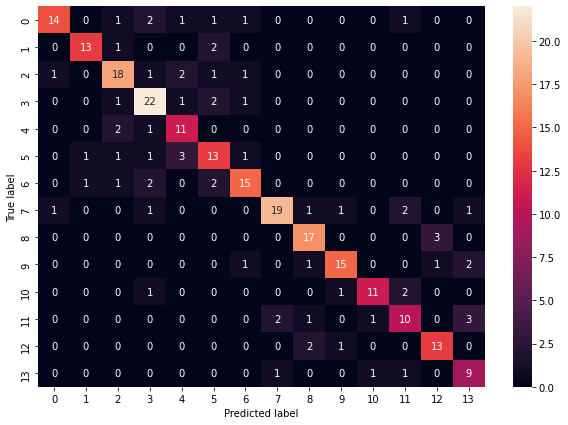

In [31]:
from sklearn.utils.multiclass import unique_labels
df_cm = pd.DataFrame(confusion_matrix1, index = unique_labels(y_test_scale, y_pred_scale), columns = unique_labels(y_test_scale, y_pred_scale))
fig, ax = plt.subplots(1, 1, figsize=(10,7))
heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
actual=y_test
actual = pd.DataFrame({'actualvalues': actual})

In [33]:
#importing KNN classifier and metric F1score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import f1_score

In [34]:
#Defining K range
k = range(1, 10, 1)

In [35]:
def Elbow(K):
    #initiating empty list
    test_error = []
   
    #training model for evey value of K
    for i in K:
        #Instance oh KNN
        clf = KNN(n_neighbors = i)
        clf.fit(x_train, y_train)
        # Appending F1 scores to empty list claculated using the predictions
        tmp = clf.predict(x_test)
        tmp = f1_score(tmp,y_test, average='weighted')
        error = 1-tmp
        test_error.append(error)
    
    return test_error

In [36]:
# calling above defined function
test = Elbow(k)

Text(0.5, 1.0, 'Elbow Curve for test')

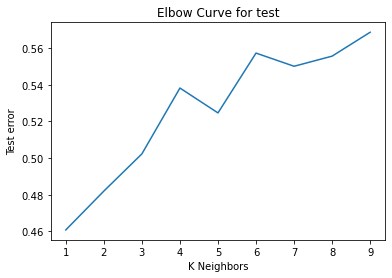

In [37]:
# plotting the Curves
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test error')
plt.title('Elbow Curve for test')

In [38]:
# Creating instance of KNN
clf = KNN(n_neighbors = 5)

# Fitting the model
clf.fit(x_train, y_train)

# Predicting over the Train Set and calculating F1
test_predict = clf.predict(x_test)
y_pred_KNN = f1_score(test_predict, y_test, average='weighted')
print('Test F1 Score    ', k )

Test F1 Score     range(1, 10)


In [39]:
#SVM

In [40]:
# import support vector classifier 
# "Support Vector Classifier"
from sklearn.svm import SVC  
#kernel = []
clf = SVC(kernel='linear') 
  
# fitting x samples and y classes 
clf.fit(x_train, y_train) 

test_predict_slv = clf.predict(x_test)
y_pred_SVC = f1_score(test_predict_slv, y_test, average='weighted')
print('Test F1 Score    ', y_pred_SVC )

Test F1 Score     0.6319846809625065


In [41]:
# training the model on training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)

# making predictions on the testing set
y_pred_NB = gnb.predict(x_test)

# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred_NB)*100)

Gaussian Naive Bayes model accuracy(in %): 30.855018587360593


In [42]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)

y_pred_LR = classifier.predict(x_test)

print ("Accuracy : ", accuracy_score(y_test, y_pred_LR))

Accuracy :  0.4795539033457249


In [43]:
from sklearn import tree
# Defining the decision tree algorithm
dtree=tree.DecisionTreeClassifier()
dtree.fit(x_train,y_train)

y_pred_DT = dtree.predict(x_test)

print ("Accuracy : ", accuracy_score(y_test, y_pred_DT))

Accuracy :  0.40148698884758366


In [44]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(x_train, y_train)

# performing predictions on the test dataset
y_pred_RFC = clf.predict(x_test)

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_RFC))

ACCURACY OF THE MODEL:  0.5910780669144982


In [45]:
modelname = ['KNN','SVM','Naive Bayes','Logistic Regression','Decision Tree','Random forest']
Accuracy_model=[y_pred_KNN*100,y_pred_SVC*100,metrics.accuracy_score(y_test, y_pred_NB)*100,accuracy_score(y_test, y_pred_LR)*100,accuracy_score(y_test, y_pred_DT)*100,metrics.accuracy_score(y_test, y_pred_RFC)*100]

In [46]:
acc_df=pd.DataFrame([modelname,Accuracy_model])
acc_df

,0,1,2,3,4,5
0,KNN,SVM,Naive Bayes,Logistic Regression,Decision Tree,Random forest
1,47.539998,63.198468,30.855019,47.95539,40.148699,59.107807


In [47]:
#